© [Mariia Seleznova](https://www.ai.math.uni-muenchen.de/members/phd_students/seleznova/index.html) 2022

https://github.com/mselezniova/MSML22

Distributed under the [Creative Commons Attribution License](https://creativecommons.org/licenses/by/4.0/)

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='svg'

import matplotlib
import matplotlib.pyplot as plt

import os

import numpy as np
import pandas as pd


import sys
sys.path.append('../../')

from utils import train_test_split, normalize

# Neural Networks

Neural networks (NNs) are machine learning models built from multiple connected linear models, called **neurons** or **perceptrons**. A neural network can be represented as a directed graph, which describes how the neurons are connected to each other. Each arrow in such a graph means that the output of the first neuron is fed into the second neuron as an argument.



<img src="https://tikz.net/wp-content/uploads/2021/12/neural_networks-001.png" alt="nn" width="700"/>

Source: https://tikz.net/neural_networks/


The graph above shows a **fully-connected** neural network, also called a **multi-layer perceptron (MLP)**. Such networks can be defined through their **depth** $L\in\mathbb{N}$ (number of layers) and  **widths** of all the layers $(n_0,\dots, n_{L+1})\in \mathbb{N}^{L+2}$. Here $n_0$ is the input dimensionality and $n_{L+1}$ is the dimensionality of the output. In our example, the network has three hidden layers, so $L=3$ and the width are given by $n_0 = 4, n_1=n_2=n_3=5, n_4 = 3$.


There are many other common NN **architecture** types, such as:

- **Convolutional NNs (CNNs)**, which are typically used for images and video data
- **Recurrent NNs (RNNs)** used for time series/sequence data (Note: RNN computation graphs include cycles, which distinguishes RNNs from all the NNs without cycles, called **feedforward** NNs)
- **Autoencoders** used for dimensionality reduction or generative models

and many others. In this class, we will only focus on fully-connected networks.


### Neuron 

To understand how a NN produces its output, we need to understand how a neuron works. Each neuron is a linear model, which takes outputs of the previous layer as input, computes an affine-linear function of the inputs, and applies a (typically non-linear) **activation function** $\sigma$ to the result.

<img src="https://tikz.net/wp-content/uploads/2021/12/neural_networks-009.png" alt="neuron" width="700"/>

Source: https://tikz.net/neural_networks/

We denote the weights matrix in layer $\ell$ as $W^{(\ell)} = (w_{ij}^{(\ell)})_{i,j} \in \mathbb{R}^{n_{\ell+1}\times n_\ell}$ and the bias vector $b^\ell = (b_i^{(\ell)})_i  \in \mathbb{R}^{n_{\ell+1}}$ for all $\ell=0\dots,L$. The the NN's output function is given by:

$$h(x) = W^{(L)}\sigma(a^{(L-1)} + b^{(L)}) = W^{(L)}\sigma\Bigl(W^{(L-1)}\sigma\Bigl(W^{(L-2)}\sigma\Bigl(\dots\Bigr) + b^{(L-2)} \Bigr) + b^{(L-1)} \Bigr) + b^{(L)}, \quad x\in\mathbb{R}^{n_0},$$

i.e. a fully-connected NN applies a composition of affine linear functions and (non-linear) activation functions to the input.

In the following, we will denote **activation** vector (i.e. the vector that we get after applying the activation function) in each layer as

$$a^{(\ell)} := \sigma\Bigl( W^{(\ell-1)}a^{(\ell-1)} + b^{(\ell-1)} \Bigr), \quad \ell=1,\dots,L,$$

and the **pre-activation** vector (i.e. the result of computing the affine-linear map in a given layer) as

$$z_i^{(\ell)} :=  W^{(\ell-1)}a^{(\ell-1)} + b^{(\ell-1)}, \quad \ell=1,\dots,L+1.$$

In the input and the output layers we have

$$a^{(0)} := x, \quad a^{(L+1)} = z^{(L+1)} = h(x).$$

**Note:** Here we considered a NN with linear output layer, i.e. there is no activation function in the last layer, and identical activation function in all the hidden layers. In general, it is possible to use different activation functions in different layers. It is particularly common to use one activation function in all the hidden layers and a different activation function (e.g. softmax) in the output layer.

## Backpropagation

Backpropagation is an algorithm for training feedforward NNs, which allows to compute the gradients of the loss efficiently and thus makes training of very large NNs possible. Consider the empirical risk function of a NN:

$$\hat{\mathcal{R}}(X,Y) = \dfrac{1}{N}\sum_{i=1}^N \mathcal{L}(y_i,h(x_i))$$

Notice that the loss directly depends only on $W^{(L)}$ and $b^{(L)}$ --- parameters of the last layer --- through $h(x)$. The dependence on $W^{(L-1)}$ is only through $a^{(L-1)}$, on $W^{(L-2)}$ --- through $a^{(L-2)}$, which itself only influences $h(x)$ only through $a^{(L-1)}$, and so on. Thus, we need to use the chain rule to compute the derivatives: 

$$\nabla_{W^{(\ell)}}\hat{\mathcal{R}} = \dfrac{\partial \hat{\mathcal{R}} }{\partial h(x)} \odot \dfrac{\partial h(x)}{\partial a^{(L-1)}} \odot \dfrac{\partial a^{(L-1)} }{\partial z^{(L-1)}}\cdot \dfrac{\partial z^{(L-1)} }{\partial a^{(L-2)}}\odot \dots \odot \dfrac{\partial a^{(\ell)} }{\partial z^{(\ell)}} \cdot \dfrac{\partial z^{(\ell)} }{\partial W^{(\ell)}}$$

Computing these derivatives straightforwardly is of course computationally expensive, since it requires $O(L)$ matrix-matrix multiplications. However, we notice that most of the computations are repeated in the chains for layer $\ell$ and $\ell+1$, so we can reuse them. Let us define the following auxiliary variables:

$$\delta_j^{(\ell)} := \dfrac{\partial \hat{\mathcal{R}}}{\partial z_j^{(\ell)}}, \quad j=1,\dots, n_{\ell}, \quad \ell =1,\dots, L+1,$$

which can be interpreted as an error caused by neuron $j$ in layer $\ell$. Then these variables can be efficiently computed layer by layer in the **reverse order** -- starting from the output layer an moving towards the imput layer. We have

$$\delta^{L+1} = \dfrac{\partial \hat{\mathcal{R}} }{\partial h(x)}$$

(or, if we have an activation function $\alpha$ in the output layer, $\delta^{L+1} = \dfrac{\partial \hat{\mathcal{R}} }{\partial h(x)}\odot \alpha'(h(x))$ ). Then, for any layer $\ell\leq L$, we have

$$\color{green}{\delta^{(\ell)}} = \dfrac{\partial \hat{\mathcal{R}}}{\partial z^{(\ell+1)}}\cdot \dfrac{\partial z^{(\ell+1)}}{\partial z^{(\ell)}} = \bigl(W^{(\ell)}\bigr)^T \color{green}{\delta^{(\ell+1)}} \odot \sigma'(z^{(\ell)})$$

Using the last expression, we can graduallu compute $\delta^{(L+1)},\dots,\delta^{(1)}$.

Now we notice that we can easily compute all the needed gradients using $\delta^{(L+1)},\dots,\delta^{(1)}$:

$$\nabla_{W^{\ell}}\hat{\mathcal{R}} = \dfrac{\partial \hat{\mathcal{R}}}{\partial z^{(\ell+1)}} \cdot \dfrac{\partial z^{(\ell+1)}}{\partial W^{\ell}} = \color{green}{\delta^{(\ell+1)}} \otimes a^{(\ell)},$$
$$\nabla_{b^{\ell}}\hat{\mathcal{R}} = \dfrac{\partial \hat{\mathcal{R}}}{\partial z^{(\ell+1)}} \cdot \dfrac{\partial z^{(\ell+1)}}{\partial b^{\ell}} = \color{green}{\delta^{(\ell+1)}},$$

where $\otimes$ denotes an outer product. Summarizing all the above observations, we get the following algorithm to perform a gradient descent update of a feedforward NN:

1. Compute the **forward pass**:
$$x \rightarrow z^{(1)} \rightarrow x^{(1)} \rightarrow z^{(2)} \rightarrow \dots \rightarrow a^{(L)} \rightarrow z^{(L+1)} $$ for every $x \in (x_i)_{i=1,\dots,N}$ in the dataset (or training batch).


2. Compute tha **backward pass**:
$$\delta^{L+1} = \dfrac{\partial \hat{\mathcal{R}} }{\partial h(x)},\quad \color{green}{\delta^{(\ell)}} = \bigl(W^{(\ell)}\bigr)^T \color{green}{\delta^{(\ell+1)}} \odot \sigma'(z^{(\ell)}), \quad \ell=L,\dots,1$$ for every $x \in (x_i)_{i=1,\dots,N}$ in the dataset (or training batch).


3. Compute the gradients:
$$\nabla_{W^{\ell}}\hat{\mathcal{R}} = \color{green}{\delta^{(\ell+1)}} \otimes a^{(\ell)}, \quad \nabla_{b^{\ell}}\hat{\mathcal{R}} = \color{green}{\delta^{(\ell+1)}}, \quad \ell=0,\dots,L$$ and average them over the training set (batch).

4. Perform a gradient descent update.

This is the backpropagation algorithm. The efficiency of backpropagation comes from the following observations:

- Backpropagation reuses all the repeated computations by using $\delta^{(\ell+1)}$ to obtain $\delta^{(\ell)}$.
- The algorithm avoids all the matrix-matrix products of the chain rule by using the fact that most interlayer derivatives are zero. 


## Activation functions

In [2]:
class ReLU:
    ''' ReLU activation and its sub-derivative. '''

    def val(self, y):
        return y*(y>0)

    def diff(self, y):
        return np.where(y>0,1,0)


class Linear:
    ''' Linear activation and its derivative. '''

    def val(self, y):
        return y

    def diff(self, y):
        return 1. 
    

## Loss function

In [3]:
class L2:
    ''' Quadratic loss value and its derivative. '''

    def val(self, X, Y):
        return .5 * np.sum((X - Y)**2)/X.shape[0]

    def diff(self, X, Y):
        return X - Y

## Dense layer implementation

In [4]:
class DenseLayer():
    def __init__(self, num_in, num_out, activation=ReLU):
        # number of in and out neurons
        self.num_in = num_in
        self.num_out = num_out
        
        self.activation = activation()
    
        self.W = np.random.normal(loc=0.,scale=np.sqrt(2./num_in),size = (num_out, num_in)) 
        self.b = np.zeros((num_out,))


    def val(self, X):
        ''' Compute the activation of all output neurons. '''
        # pre-activation vector
        z = X@self.W.T + self.b
        
        # activation vector
        x = self.activation.val(z)
        
        return z, x
    
    def compute_delta(self, z, W_next, delta_next):
        '''Compute backpropagated error delta^l from delta^l+1'''
        delta = self.activation.diff(z)*(delta_next@W_next)
        return delta


    def update(self,X_prev, delta, lr):
        
        '''Compute gradients using delta^l'''
        delta_W = np.mean(delta[:,:,np.newaxis]*X_prev[:,np.newaxis,:],axis=0)
        delta_b = np.mean(delta,axis=0)
        
        ''' Update rule for this layer. '''
        self.W -= lr * delta_W
        self.b -= lr * delta_b
    

## Fully-connected NN (MLP) implementation

In [5]:
class MLP():
    def __init__(self, widths, activation, output_activation=Linear, loss=L2):
        self.widths = widths
        self.layers = [DenseLayer(self.widths[l],self.widths[l+1],activation=activation) 
                       for l in range(len(self.widths)-2)]
        self.layers.append(DenseLayer(self.widths[-2],self.widths[-1],activation=output_activation) )
        self.loss = loss()
        
        self.history = [{'loss': None,
                         'accuracy': None}]
        
        self.train_started = 0
        
     
    def _labels_encoding(self, Y):
        self.labels = np.unique(Y)
        K = self.labels.size
        y_t = np.zeros(Y.shape+(K,))
    
        for k in range(K):
            ind = np.argwhere(Y==self.labels[k]).T.tolist()
            ind.append([k]*len(ind[0]))
            y_t[tuple(ind)] = 1

        return y_t
    
    def accuracy(self, X, Y):
        
        pred = np.argmax(self.h(X),axis=-1).ravel()
        return 1. - np.mean(self.labels[pred] != Y.ravel())
    
    def _loss(self, X, _Y):
        return self.loss.val(self.h(X),_Y)
    
    def forward_pass(self,X):
        x_l = [X]
        z_l = [X]
        for layer in self.layers:
            
            z, x = layer.val(x_l[-1])
            
            x_l.append(x)
            z_l.append(z)

        return z_l, x_l
    
    def h(self,X):
        out = X
        for layer in self.layers:
            
            _, out = layer.val(out)

        return out
        
    
    def train(self, X, Y,num_iter=10,lr=1e-3):
 
        _Y = self._labels_encoding(Y)
    
        if self.train_started == 0:
            self.history[0]['loss'] = self._loss(X,_Y)
            self.history[0]['accuracy'] = self.accuracy(X,Y)
            self.train_started = 1
        
        for e in range(num_iter):
            
            z_l, x_l = self.forward_pass(X)

            L_diff = self.loss.diff(x_l[-1], _Y)
            delta_next = L_diff*self.layers[-1].activation.diff(z_l[-1])    
            delta_l = [delta_next]
            
            for i in reversed(range(1, len(self.layers)-1)):
                
                delta_next = self.layers[i].compute_delta(z_l[i+1],self.layers[i+1].W,delta_l[-1])
                delta_l.append(delta_next)

            delta_next = self.layers[0].compute_delta(z_l[1],self.layers[1].W,delta_l[-1])
            delta_l.append(delta_next)
            
            delta_l = delta_l[::-1]


            for i, layer in enumerate(self.layers):
                layer.update(x_l[i],delta_l[i],lr=lr)
             
            loss = self._loss(X,_Y)
            acc = self.accuracy(X,Y)
            self.history.append({'loss': loss,
                                 'accuracy': acc})
                

## Test on Iris data

In [6]:
file_name = 'iris_data_set.csv'
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
column_names = ['sepal length [cm]', 'sepal width [cm]',
                'petal length [cm]', 'petal width [cm]', 'iris type']

if os.path.exists(file_name):
    print(f'Loading data from local file `{file_name}`...')
    df = pd.read_csv(file_name, index_col=0)
else:
    print(f'Loading data from `{url}`...')
    df = pd.read_csv(url, names=column_names)
    df.to_csv(file_name)
    print('Done.')

Loading data from local file `iris_data_set.csv`...


In [7]:
training_data_fraction = 0.8

df, train_df, test_df =  train_test_split(df, training_data_fraction)

X = df[['sepal length [cm]', 'petal width [cm]']].to_numpy()
Y = df['iris type'].to_numpy()

train_X = train_df[['sepal length [cm]', 'petal width [cm]']].to_numpy()
train_Y = train_df['iris type'].to_numpy()

test_X = test_df[['sepal length [cm]', 'petal width [cm]']].to_numpy()
test_Y = test_df['iris type'].to_numpy()

print('Training data split as follows:')
print(f'  Training data samples: {len(train_df)}')
print(f'      Test data samples: {len(test_df)}')

Training data split as follows:
  Training data samples: 120
      Test data samples: 30


In [8]:
widths = [X.shape[-1],100,np.unique(Y).size]

model = MLP(widths,activation=ReLU,output_activation=Linear,loss=L2)

In [9]:
model.train(train_X,train_Y,lr=1e-3,num_iter=10000)

The final train accuracy: 90.8%
Test accuracy: 90.0%


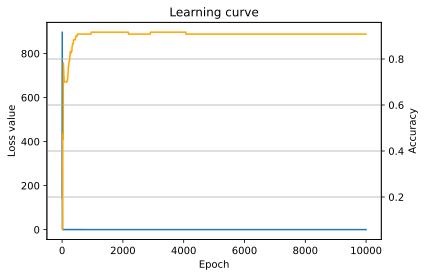

In [10]:
fig, ax = plt.subplots()

loss_history = [h['loss'] for h in model.history]
acc_history = [h['accuracy'] for h in model.history]

ax.plot(range(len(model.history)), loss_history)
ax.set_ylabel('Loss value')

ax2 = ax.twinx()
ax2.plot(range(len(model.history)), acc_history, color='orange')
ax2.set_ylabel('Accuracy')

ax.set_xlabel('Epoch')

plt.title('Learning curve')
plt.grid()

print(f'The final train accuracy: {round(100*acc_history[-1],1)}%')
print(f'Test accuracy: {round(100*model.accuracy(test_X, test_Y),1)}%')

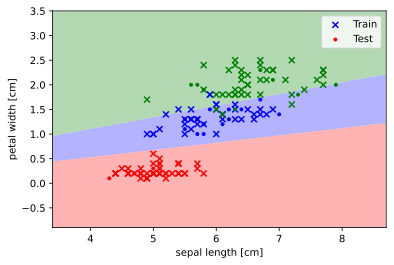

In [11]:
fig, ax = plt.subplots()

x1_min = train_X[:, 0].min() - 1
x1_max = train_X[:, 0].max() + 1
x2_min = train_X[:, 1].min() - 1
x2_max = train_X[:, 1].max() + 1

x1_list, x2_list = np.meshgrid(np.arange(x1_min, x1_max, .01), 
                               np.arange(x2_min, x2_max, .01))

X_list = np.dstack([x1_list, x2_list])
h_list = np.argmax(model.h(X_list),axis=-1)

cmap = matplotlib.colors.ListedColormap(['red', 'blue', 'green'])
plt.contourf(x1_list, x2_list, h_list, cmap=cmap, alpha=.3)

colors = train_df['iris type'].replace(model.labels,['red','blue','green'])
plt.scatter(train_X[:, 0], train_X[:, 1], marker='x',color=colors, label='Train')

colors = test_df['iris type'].replace(model.labels,['red','blue','green'])
plt.scatter(test_X[:, 0], test_X[:, 1], marker='.',color=colors, label='Test')


plt.xlabel('sepal length [cm]')
plt.ylabel('petal width [cm]')
plt.xlim(x1_min, x1_max)
plt.ylim(x2_min, x2_max)
plt.legend()

## Problems with NN training

Neural networks are way more **expressive** than linear models. Even if we consider only NNs with one hidden layer, we can find a model among these NNs that appxomates any given continous function with arbitrary precision (see [universal approximation theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem)). However, it is usually not clear how to find such a model in practice. Notice the following:

- The objective (risk) function of NNs is **not convex** (at the very least, it is possible to "replace" neurons in a network so that the output function does not change; i.e. there exist many choices of parameters ordering, which do not affect the model's output and loss values).
- Since the objective function is not convex, it may have many local minima, possibly with very different performace. Training with GD converges to a local minimum closest to the initilialization. Thus, the learning curve and the performance of NNs may depend significantly on **initialization**. 

Since it is challenging to study the training dynamics of NNs theoretically, there aren't rigorous "recipies" how to construct a train a NN in the best way for a given problem. However, there are numerous heuristics that have proved themselves useful in practice. These heuristics often concern the choice of:

- **Architecture**, i.e. NN's depth, width, kinds of layers and their ordering, activation functions, etc.
- **Optimization method**: since NNs' optimization problem is non-convex, it is common to use optimization methods beyond vanilla GD, which are designed to avoid local minima, adapt learning rate, etc., to train NNs.
- **Initialization**: there are several common initialization strategies used for NNs.

We will speak more about these heuristics in the next classes. 

## Exercise

Implement **sigmoid activation function** and **cross-entropy loss** as separate classes. Try training MLPs with different combinations of activation functions (in hidden layers and in the output layer) and loss function. Plot learning curves and decision boundaries. Which combinations work well and which do not? Why?